# <span style="color:turquoise">Text classification with pytorch</span>


An example of using natural language processing for sentiment analysis. <br> Building a binary classifier of movie reviews that will predict if a review is positive or negative.




__Dataset:__ IMDB movie reviews from Kaggle<br>
__Model:__ LSTM


### <span style="color:teal">Todo:</span>

- ~~Read dataset~~
- ~~Preprocess text~~
- ~~Split into train, validation, and test sets~~
- ~~Convert text to indices and add paddings~~
- ~~Make model~~
- ~~Make training function~~
- ~~Make evaluation function~~
- ~~Train~~
- Evaluate on test set
- Run inference

In [1]:
import csv
import random
import numpy as np
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## <span style="color:teal">Read the data and split it into training, cross-validation, and test sets</span>

In [2]:
class Reviews():
    
    def __init__(self):
        self.train = {}
        self.val = {}
        self.test = {}
        self.LABELS = {"positive":1, "negative": 0}
        self.COUNT = {"positive": 0, "negative": 0}
    
    
    def read_data(self):
        
        dataset = []
        
        with open ("IMDB_Dataset.csv", newline='') as f:
            datareader = csv.reader(f, delimiter=',')
            next(datareader, None)

            for row in datareader:
                dataset.append([row[0], self.LABELS[row[1]]])
                self.COUNT[row[1]] += 1
            
            random.shuffle(dataset)
                
        return dataset




    def split_dataset(self,
                      dataset,
                      split=[int(50000*0.6), int(50000*0.2), int(50000*0.2)]):
        
        train, val, test = torch.utils.data.random_split(dataset,
                                               split,
                                               generator=torch.Generator().manual_seed(43))
          
            
        return train, val, test

In [3]:
rev = Reviews()
data = rev.read_data()
pos_count = rev.COUNT["positive"]
neg_count = rev.COUNT["negative"]


In [4]:
print(data[10])

["I'm not a fan of Adam Sandler. In fact, I don't think I've ever liked him in anything I've seen him in. The opening scene of this movie confirmed my worst fears. There was Adam Sandler, playing a somewhat ridiculous looking character riding around New York City on a motor scooter, looking pitiful and lost. Typical Sandler-type loser character again, I thought. I almost gave up then and there. But then, as I stuck with this, I actually discovered something I never knew before: Adam Sandler can act! He is truly outstanding in this movie as Charlie, a lost and lonely figure, whose entire family (including the dog) was killed in one of the hijacked planes on 9/11 and who has apparently lost all touch with reality as a result. Don Cheadle plays his former college roommate who unexpectedly reconnects with Charlie and takes it on as his mission to help him get better. Of course, Cheadle's Alan Johnson has his own problems and sources of unhappiness, and somehow these two men manage to help 

In [5]:
train, val, test = rev.split_dataset(data)
print(train[10])

["An EXTREMELY fast paced,exhilarating, interesting, detail rich book. Its a huge shame that the film had none of these qualities. not only was Tom Hanks' mild mannered portrayal or Robert Langdon Laughable, but the name changes to key characters, huge deviances from the original story line, and poor Irish/Italian accent from Carmalengo Played by Ewan Mcgregor, made for the worst book to film EVER. i would recommend reading the book to understand that, if Ron Howard must insist on making ANOTHER book to film, i would be happy saving my £6.40 for a KFC zinger meal and some chicken wings - far more entertaining and deeply more satisfying!", 0]


In [6]:
print(len(train), len(val), len(test))

30000 10000 10000


In [7]:
def split_x_and_y(data):
    x = []
    y = []
    for review, label in data:
        x.append(review)
        y.append(label)
    return x, np.array(y)

In [8]:
train_x_raw, train_y = split_x_and_y(train)
val_x_raw, val_y = split_x_and_y(val)
test_x_raw, test_y = split_x_and_y(test)


print(len(train_x_raw), len(train_y))
print(train_x_raw[50], train_y[50])

30000 30000
Every Saturday morning at 11 a.m. I watched Superstars. All the biggest events happened on this show at the time. Challenge, which aired Sunday mornings, was decent too, but all the big stuff happened on this show. Wrestlers would do all their interviews with Mean Gene on a platform next to the live crowd or talk on their own to the screen in front of a background that promoted them. The matches were usually squashes but sometimes you would see 2 mid carders square off in the main event. There were also interview shows that usually resulted in violence thus setting up a feud. These segments ranged from Pipers Pit, The Body Shop, The Flower Shop, The Snake Pit, The Brother Love Show, The Funeral Parlor, and The Barber Shop. I don't recall any titles changing hands on this show. That usually happened at pay per views and Saturday Nights Main Event. 1


## <span style="color:teal">Preprocess text</span>

In [9]:
def preprocess(review,
               remove_stopwords=False, 
               remove_html=True, 
               remove_punct=False, 
               lowercase=False, 
               lemmatize=False,
               maxlen=128):
    
    review = re.sub(r"\'", "'", review)
    review = re.sub(r"\x96", "-", review)
    
    if remove_html:
        review = re.sub(r'<.*>', ' ', review)
    
    review = word_tokenize(review)
        
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        review = [w for w in review if w not in stop_words]
        
    if remove_punct:
        contractions = ["'ll", "'s", "n't", "'d", "'m", "'ve", "'re"]
        review = [w for w in review if w.isalnum() or w in contractions]
    
    if lowercase:
        review = [w.lower() for w in review]
        
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        review = [lemmatizer.lemmatize(w) for w in review]
    
    
    return review[:maxlen]
    


In [10]:
train_words = [preprocess(review, 
                      lowercase=True, 
                      remove_punct=True,
                      remove_stopwords=True
                     ) 
           for review in train_x_raw]

val_words = [preprocess(review, 
                    lowercase=True, 
                    remove_punct=True,
                    remove_stopwords=True
                   ) 
         for review in val_x_raw]

In [11]:
print(train_words[9592], '\n', val_words[3029])
print(len(train_words[9592]), '\n', len(val_words[3029]))

['this', 'movie', 'disappointment', 'i', 'looking', 'forward', 'seeing', 'good', 'movie', 'i', 'type', 'person', 'starts', 'movie', "n't", 'turn', 'end', 'i', 'forcing', 'turn', 'i', 'also', 'agree', 'anthony', 'hopkins', 'needs', 'stick', 'acting', 'by', 'time', 'movie', 'i', "n't", 'even', 'get', 'plot', 'i', 'confused', 'annoyed'] 
 ['corey', 'haim', 'never', 'going', 'known', 'one', 'great', 'actors', 'time', 'least', 'movies', 'like', 'licensed', 'to', 'drive', 'element', 'lowbrow', 'humor', 'a', 'somewhat', 'better', 'translation', 'dean', 'koontz', 'book', 'capable', 'thriller', 'phantoms']
39 
 28


In [12]:
print(len(train_words))

30000


## <span style="color:teal">Convert text to indices and add paddings</span>

In [13]:
def make_vocabulary(preprocessed_data, 
                    vocab_size=15000,
                    pad_token='<PAD>',
                    unk_token='<UNK>'):
    
    # Create a vocabulary list of a given size
    freqs = {}
    for review in preprocessed_data:
        for word in review:
            freqs[word] = freqs.get(word, 0) + 1
            
    freqs_list = Counter(freqs).most_common(vocab_size)
    
    assert len(freqs_list) == vocab_size
    
    # Create word-index mappings
    vocab_list = [pair[0] for pair in freqs_list]
    word2ind = {word : i+2 for i, word in enumerate(vocab_list)}
    ind2word = {i+2 : word for i, word in enumerate(vocab_list)}
    
    # Prepend the pad token
    word2ind[pad_token] = 0
    ind2word[0] = pad_token
    
    # Prepend the 'unknown' token
    word2ind[unk_token] = 1
    ind2word[1] = unk_token
    
    assert len(word2ind) == len(ind2word)

    
    return word2ind, ind2word
  
    

In [14]:
word2ind, ind2word = make_vocabulary(train_words, vocab_size=10000)

print(len(word2ind), len(ind2word))
print(word2ind['i'], word2ind['awful'])
print(ind2word[1700], ind2word[3893])

10002 10002
2 235
grand spring


In [15]:
del train_x_raw, val_x_raw

In [16]:
print(np.max([len(x) for x in train_words]))
print(np.mean([len(x) for x in train_words]))

print(np.max([len(x) for x in val_words]))
print(np.mean([len(x) for x in val_words]))

128
71.17573333333333
128
71.2365


In [17]:
def make_padded_inputs(preprocessed_data, 
                       vocab, 
                       padded_length=64,
                       pad_token='<PAD>',
                       unk_token='<UNK>'):
    
    num_lines = len(preprocessed_data)
    pad = vocab[pad_token]
    
    inputs = np.full((num_lines, padded_length), pad)
    
    for i, review in enumerate(preprocessed_data):
        start_position = padded_length - len(review)
        for j, word in enumerate(review):
            inputs[i, (start_position + j)] = vocab.get(word, vocab[unk_token])       
    return inputs
            

In [18]:
train_x = make_padded_inputs(train_words, word2ind)
val_x = make_padded_inputs(val_words, word2ind)


print(f"""Training example at indices 5 and 6:\n{train_words[5:7]}\n
    Converted to indices:\n{train_x[5:7, :]}\n""")

print(len(train_words[5]), np.count_nonzero(train_x[5]))

assert (len(train_words[5]) == np.count_nonzero(train_x[5])) or (64 == np.count_nonzero(train_x[5]))

Training example at indices 5 and 6:
[['simply', 'put', 'oliver', 'one', 'greatest', 'musicals', 'time', 'it', 'filled', 'memorable', 'songs', 'food', 'glorious', 'food', 'oliver', 'consider', 'yourself', 'name', 'equally', 'memorable', 'characters', 'the', 'film', 'shot', 'solely', 'studios', 'soundstages', 'shepperton', 'film', 'studios', 'translate', 'film', 'the', 'sets', 'perfectly', 'replicate', 'victorian', 'london', 'costumes', 'worn', 'characters', 'a', 'winner', 'massive', 'success', 'release', 'oliver', 'worthy', 'contender', 'best', 'musical', 'time', 'delight', 'anyone', 'loves', 'film'], ['what', 'i', "'ve", 'seen', 'wolfgang', 'petersen', "'s", 'films', 'pretty', 'good', 'he', 'knows', 'direct', 'action', 'create', 'suspense', 'get', 'interested', 'eastwood', 'tends', 'great', 'sometimes', 'excellent', 'this', 'goes', 'acting', 'directing', 'they', 'hand', 'solid', 'work', 'the', 'concept', "n't", 'bad', 'game', 'works', 'well', 'malkovich', 'performs', 'rather', 'well',

## <span style="color:teal">Load data into torch</span>

In [19]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

In [20]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [21]:
print(list(train_loader)[0][0][:5], '\n', list(train_loader)[0][1][:5],)

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  115, 2395,  810,  215,
          135,  575,   65,    2,   55, 5705,  164, 4677,    1, 7354, 5166, 4303,
           66,  940,  156,  523,   38, 3092,    1,    3,   66,  492,  103, 5246,
          543,   25,    1, 2447],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,  182,    2,   26,   76,  960,   65,  370,
            2,  960,    2,   88, 6836,    2,   61, 3885,    2,   57,   34, 3373,
            2,  312,    1,  211,  213,  151,  233, 1638,  175, 3032,  123,  646,
            1,    1,  660,  658,  382,   24,   48,  660, 2536,  291,   10,   13,
           19,  270,  258,    4],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,   

In [22]:
print(train_words[:1])
print(len(train_words[0]))
print(train_y[0])

[['may', 'contain', 'spoilers', 'for', 'last', 'four', 'years', 'i', "'ve", 'keen', 'fan', 'ali', 'sacha', 'baron', 'cohen', 'undoubtedly', 'funny', 'intelligent', 'guy', 'view', 'best', 'creation', 'borat', "'s", 'funny', 'hell', 'quite', 'shameless', 'says', 'people', 'canberra', 'australia']]
32
0


In [23]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, 
                 vocab_size, 
                 d_feature, 
                 num_layers, 
                 hidden_size,
                 n_outputs,
                 bidirectional=False,
                 dropout_rate=0.001):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_feature)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lstm = nn.LSTM(input_size=d_feature,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, n_outputs)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, input_data): 
        
        embedded = self.dropout(self.embedding(input_data))
        lstm_out, _ = self.lstm(embedded)
        fc = self.fc(lstm_out[:,-1,:])
        sigmoid = self.sigmoid(fc)
   
        return sigmoid
    

In [24]:
vocab_size = len(word2ind)
d_feature = 64
hidden_size = 128
n_outputs = 1
num_layers = 2

model = SentimentClassifier(
                            vocab_size=vocab_size, 
                            d_feature=d_feature,  
                            num_layers=num_layers, 
                            hidden_size=hidden_size, 
                            n_outputs=n_outputs).to(device)

print(model)

SentimentClassifier(
  (embedding): Embedding(10002, 64)
  (dropout): Dropout(p=0.001, inplace=False)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## <span style="color:teal">Train model</span>

In [25]:
def accuracy(outputs, targets):
    outputs = torch.flatten(outputs)
    assert outputs.shape == targets.shape
    predicted = torch.where(outputs>=0.5, 1, 0)
    accuracy = torch.Tensor.float(predicted==targets).mean()
    return accuracy

In [26]:
def train_model(train_loader=train_loader,
             val_loader=val_loader,
             model=model,
             criterion=nn.BCELoss(),
             n_epochs=6):
    
    start_time = time.time()
    
    train_losses = []
    val_losses = []
    accs = []
    val_accs = []
    
    for epoch in range(n_epochs):
        total_loss = 0
        total_loss_val = 0
        total_acc = 0
        total_acc_val = 0
        
        model.train()
        
        for inputs, labels in train_loader: 
            optimizer= torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler= StepLR(optimizer, step_size=n_epochs//2, gamma=0.1)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.float())
            acc = accuracy(output, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
            total_loss += loss.item()
            total_acc += acc.item()
            
        train_losses.append(total_loss/len(train_loader))
        accs.append(total_acc/len(train_loader))
        model.eval()
        
        
        for val_inputs, val_labels in val_loader:
            val_output = model(val_inputs)
            val_loss = criterion(val_output.squeeze(), val_labels.float())
            val_acc = accuracy(val_output, val_labels)
            total_loss_val += val_loss.item()
            total_acc_val += val_acc.item()
            
            
        val_losses.append(total_loss_val/len(val_loader))
        val_accs.append(total_acc_val/len(val_loader))
        
        scheduler.step()
        
        print(f"Epoch: {epoch+1}/{ n_epochs}\t",
              f"{((time.time() - start_time) / 60):.2f} min\t",
              f"Loss: {total_loss/len(train_loader):.3f}\t",
              f"Val Loss: {total_loss_val/len(val_loader):.3f}\t",
              f"Acc: {total_acc/len(train_loader):.3f}\t",
              f"Val Acc: {total_acc_val/len(val_loader):.3f}")
            
    print(f"Training completed in {(time.time() - start_time) / 60} min.")
    
    return accs, val_accs, train_losses, val_losses
    

In [27]:
accs, val_accs, train_losses, val_losses = train_model(n_epochs=10)

Epoch: 1/10	 1.28 min	 Loss: 0.603	 Val Loss: 0.508	 Acc: 0.672	 Val Acc: 0.756
Epoch: 2/10	 2.60 min	 Loss: 0.486	 Val Loss: 0.442	 Acc: 0.771	 Val Acc: 0.793
Epoch: 3/10	 3.89 min	 Loss: 0.438	 Val Loss: 0.423	 Acc: 0.804	 Val Acc: 0.801
Epoch: 4/10	 5.19 min	 Loss: 0.412	 Val Loss: 0.416	 Acc: 0.817	 Val Acc: 0.811
Epoch: 5/10	 6.50 min	 Loss: 0.391	 Val Loss: 0.402	 Acc: 0.828	 Val Acc: 0.816
Epoch: 6/10	 7.80 min	 Loss: 0.377	 Val Loss: 0.400	 Acc: 0.836	 Val Acc: 0.819
Epoch: 7/10	 9.11 min	 Loss: 0.361	 Val Loss: 0.413	 Acc: 0.849	 Val Acc: 0.813
Epoch: 8/10	 10.42 min	 Loss: 0.346	 Val Loss: 0.409	 Acc: 0.858	 Val Acc: 0.814
Epoch: 9/10	 11.74 min	 Loss: 0.331	 Val Loss: 0.412	 Acc: 0.863	 Val Acc: 0.815
Epoch: 10/10	 13.05 min	 Loss: 0.318	 Val Loss: 0.421	 Acc: 0.872	 Val Acc: 0.807
Training completed in 13.051965645949046 min.


In [28]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_losses, label="val")
    plt.plot(train_losses, label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [29]:
def plot_accuracies(accuracies, val_accuracies):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracies")
    plt.plot(val_accuracies, label="val")
    plt.plot(accuracies, label="train")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

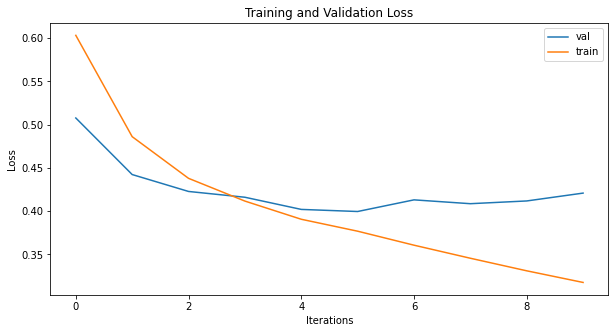

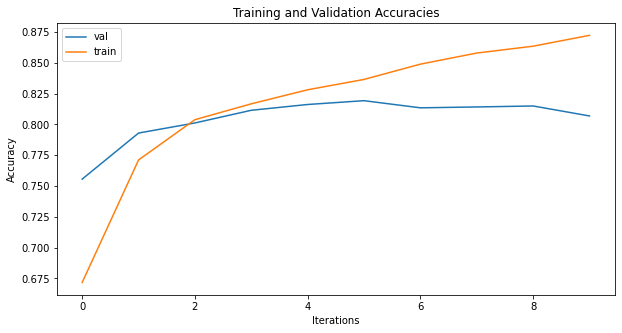

In [30]:
plot_losses(train_losses, val_losses)
plot_accuracies(accs, val_accs)
# 10 epochs, vocab_size=10000, batch_size=32, embedding_size=64, hidden_size=128, dropout=0.5
# gradient clipping: max_norm=2, norm_type=2
# decaying lr 0.001  > 0.0001